In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import requests
import warnings
import numpy as np
import streamlit as st
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import plotly.express as px
import scipy.stats as stats
warnings.filterwarnings("ignore")

In [2]:
# Read cloture dataset (downloaded from senate.gov)
clotures = pd.read_csv('senate_clotures.csv')
clotures = clotures.sort_values(by = "Congress")[:-1]

In [3]:
# Fill in info for each Congress (from cloture data and congress.gov)
senate = pd.DataFrame(columns = ('Congress',))
senate['Congress'] = np.arange(101, 117).tolist()
senate['Cloture Motions'] = clotures[clotures.Congress > 100]['Motions Filed'].reset_index()['Motions Filed']
senate['Cloture Votes'] = clotures[clotures.Congress > 100]['Votes on Cloture'].reset_index()['Votes on Cloture']
senate['Cloture Invoked'] = clotures[clotures.Congress > 100]['Cloture Invoked'].reset_index()['Cloture Invoked']
senate['Invocation Rate'] = senate['Cloture Invoked'] / senate['Cloture Votes']
senate['Republicans'] = [45, 44, 43, 52, 55, 55, 50, 51, 55, 49, 41, 47, 45, 54, 51, 53]
senate['Independents'] = [0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
senate['Democrats'] = 100 - senate['Republicans'] - senate['Independents']
senate['Guaranteed Bipartisan'] = np.maximum(senate['Democrats'] + senate['Republicans'] / 2, senate['Republicans'] + senate['Democrats'] / 2)
senate['Bills Passed'] = [679, 719, 536, 485, 566, 780, 521, 730, 665, 537, 433, 349, 362, 418, 552, 483]
senate['Bills Rejected'] = [0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0]
senate['Bills Introduced (S)'] = [3271, 3390, 2569, 2199, 2655, 3287, 3181, 3035, 4122, 3741, 4059, 3716, 3020, 3548, 3805, 5086] 
senate['Bills Introduced (HR)'] = [592, 616, 524, 490, 530, 708, 566, 618, 616, 943, 722, 491, 581, 773, 998, 777]
senate['Senate Actions'] = [7405, 7687, 5828, 8101, 7001, 8265, 8746, 7804, 10160, 10327, 9810, 7912, 7838, 9475, 8861, 8765]
senate['House Actions'] = [1077, 1122, 920, 906, 1017, 1301, 1116, 1249, 1281, 1969, 1751, 761, 834, 1054, 1322, 1050]
senate['Bills Introduced'] = senate['Bills Introduced (S)'] + senate['Bills Introduced (HR)']
senate['Nominations'] = [1462, 1259, 1820, 1146, 1243, 1145, 1718, 1681, 1828, 1766, 2184, 1807, 1798, 1632, 2291, 2042]
senate['Treaty Documents'] = [81, 97, 88, 96, 119, 117, 64, 71, 70, 72, 42, 43, 47, 60, 56, 53]
senate['Total Actions'] = senate['Senate Actions'] + senate['House Actions'] + senate['Nominations'] + senate['Treaty Documents']
senate['Cloture Frequency'] = senate['Cloture Motions'] / senate['Total Actions']
senate['Senate Output'] = (senate['Bills Passed'] + senate['Bills Rejected']) / senate['Bills Introduced']

In [4]:
header = {
          "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
          "X-Requested-With": "XMLHttpRequest"
        }

In [5]:
num_filibustered_bills = []
num_blocked_bills = []
num_compromises = []
filibustered_bills_dfs = []

for i in range(101, 117):
    # Read roll call votes for each Senate session
    url_1 = 'https://www.senate.gov/legislative/LIS/roll_call_lists/vote_menu_' + str(i) + '_1.htm'
    url_2 = 'https://www.senate.gov/legislative/LIS/roll_call_lists/vote_menu_' + str(i) + '_2.htm'
    r_1 = requests.get(url_1, headers=header)
    r_2 = requests.get(url_2, headers=header)

    df_1 = pd.read_html(r_1.text)[0]
    df_1["Session"] = 1
    df_2 = pd.read_html(r_2.text)[0]
    df_2["Session"] = 2
    df = pd.concat([df_1, df_2])

    # Get roll call votes related to invoking cloture
    cloture_votes = df[df['Question: Description'].str.contains('Cloture', na = False)]
    cloture_votes = cloture_votes[cloture_votes['Issue'].str.contains('|'.join(['S. \d+', 'H.R. \d+']), regex = True)]
    cloture_votes = cloture_votes[~cloture_votes['Question: Description'].str.contains('|'.join(['Amdt', 'Amendment']), case = False)]
    cloture_votes['Vote'] = cloture_votes['Vote (Tally)'].str.split(expand = True)[0].astype(int)
    cloture_votes = cloture_votes.sort_values(['Issue', 'Session', 'Vote'])

    # Find number of filibustered bills
    filibustered_bills = cloture_votes.drop_duplicates(subset = 'Issue', keep = 'last')
    num_filibustered_bills.append(len(filibustered_bills))
    filibustered_bills_dfs.append(filibustered_bills)

    # Find number of blocked bills
    rejected_clotures = filibustered_bills[filibustered_bills['Result'] == 'Rejected']
    num_blocked_bills.append(len(rejected_clotures))

    # Find all issues for which cloture was ultimately invoked
    issues = cloture_votes['Issue']
    rejected_issues = rejected_clotures['Issue']
    not_rejected = cloture_votes[~issues.isin(rejected_issues)]
    not_rejected_issues = not_rejected['Issue']
    cloture_invoked = not_rejected[not_rejected_issues.isin(not_rejected_issues[not_rejected_issues.duplicated()])].sort_values(['Issue', 'Session', 'Vote'])
    
    # Find number of clotures that were initially rejected and later invoked
    compromises = []
    for j in range(1, len(cloture_invoked)):
        issue = cloture_invoked.iloc[j]['Issue']
        prev_issue = cloture_invoked.iloc[j - 1]['Issue']
        result = cloture_invoked.iloc[j]['Result']
        prev_result = cloture_invoked.iloc[j - 1]['Result']
        compromise = (issue == prev_issue) and (prev_result == "Rejected") and (result == "Agreed to")
        compromises.append(compromise)
        if (compromise) and (j < len(cloture_invoked) - 1):
            next_issue = cloture_invoked.iloc[j + 1]['Issue']
            next_result = cloture_invoked.iloc[j + 1]['Result']
            if (issue == next_issue) and (next_result == "Rejected"):
                print(issue)
        elif compromise:
            if result == "Rejected":
                print(issue)
    num_compromises.append(sum(compromises))

senate['Filibustered Bills'] = num_filibustered_bills
senate['Ultimately Blocked'] = num_blocked_bills
senate['Blocked and Later Considered'] = num_compromises
senate['Cloture Initially Invoked'] = senate['Filibustered Bills'] - senate['Ultimately Blocked'] - senate['Blocked and Later Considered']

In [6]:
table_1 = senate[['Congress', 'Bills Introduced', 'Filibustered Bills', 'Ultimately Blocked', 'Blocked and Later Considered', 'Cloture Initially Invoked']]
table_1.to_csv('filibuster_table_1.csv')

In [7]:
def present_in_href(check_string):
    return lambda tag: tag.get("href") and check_string in tag.get("href")

# Reads congress.gov to determine whether a bill has bipartisan co-sponsors
def bipartisan_cosponsors(congress_num, bill_num):
    rep, dem = False, False
    bill = 'https://www.congress.gov/bill/' + str(congress_num) + 'th-congress/senate-bill/' + str(bill_num) + '/cosponsors'
    r = requests.get(bill, headers=header)
    bs = BeautifulSoup(r.content, 'html.parser')
    cosponsors = str(bs.find_all(present_in_href("https://www.congress.gov/member")))
    rep = re.search('\[R', cosponsors)
    dem = re.search('\[D', cosponsors) or re.search('\[I', cosponsors)
    if rep and dem:
        return True
    else:
        return False

# Reads senate.gov to determine whether a roll call approved bill passed with bipartisan support
def bipartisan_passage(congress_num, session_num, vote_num):
    rep_maj_support, dem_maj_support = False, False
    vote = "https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=" + str(congress_num) + "&session=" + str(session_num) + "&vote=00" + vote_num
    r = requests.get(vote, headers=header)
    bs = BeautifulSoup(r.content, 'html.parser')
    roll_calls = bs.find_all(class_="newspaperDisplay_3column")
    if roll_calls:
        yea_votes = str(roll_calls[1])
    else:
        print(congress_num)
        print(session_num)
        print(vote_num)
        return False
    yea_vote_text = ''
    for x in bs.find_all(class_="contenttext"):
        if str(x).count('YEAs') > 0:
            yea_vote_text = str(x)
    yeas = int(re.findall(r'\d+', yea_vote_text)[0])
    rep_yeas = yea_votes.count('(R')
    dem_yeas = yea_votes.count('(D') + yea_votes.count('(I')
    if rep_yeas + dem_yeas != yeas:
        print(congress_num)
        print(session_num)
        print(vote_num)
        return False
    rep_maj_support = rep_yeas > senate['Republicans'][congress_num - 101] / 2
    dem_maj_support = dem_yeas > senate['Democrats'][congress_num - 101] / 2
    if rep_maj_support and dem_maj_support:
        return True
    else:
        return False

In [8]:
# Find number of bipartisan co-sponsored Senate-introduced bills for each Congress
bipartisan_cosponsorships = []
for i in range(101, 117):
    num_bills = senate['Bills Introduced'][i - 101]
    is_bipartisan = [bipartisan_cosponsors(i, j) for j in tqdm(range(1, num_bills + 1))]
    bipartisan_cosponsorships.append(sum(is_bipartisan))

# Results of the above code are below (running the above takes a few hours)
# bipartisan_cosponsorships = [1383, 1288, 957, 790, 993, 1315, 1383, 1412, 1488, 1758, 1386, 1092, 1186, 1475, 1797, 2247]

senate['Bipartisan Cosponsored Bills'] = bipartisan_cosponsorships
senate['Bipartisan Cosponsorship Rate'] = bipartisan_cosponsorships / senate['Bills Introduced (S)']

In [9]:
num_passed_by_roll_call = []
num_passed_by_bipartisan_roll_call = []

for i in range(101, 117):
    # Read roll call votes for each Senate session
    url_1 = 'https://www.senate.gov/legislative/LIS/roll_call_lists/vote_menu_' + str(i) + '_1.htm'
    url_2 = 'https://www.senate.gov/legislative/LIS/roll_call_lists/vote_menu_' + str(i) + '_2.htm'
    r_1 = requests.get(url_1, headers=header)
    r_2 = requests.get(url_2, headers=header)
    
    df_1 = pd.read_html(r_1.text)[0]
    df_1["Session"] = 1
    df_2 = pd.read_html(r_2.text)[0]
    df_2["Session"] = 2
    df = pd.concat([df_1, df_2])

    # Find bills that passed
    bills = df[df['Question: Description'].str.contains('On Passage of the Bill', na = False)]
    bills_passed = bills[bills.Result == 'Passed']
    
    # Any bills with more 'yea' votes than this threshold (which is the sum of the majority
    # party's members and half of the minority party) is guaranteed to have passed
    # with bipartisan approval
    guarantee_threshold = senate['Guaranteed Bipartisan'][i - 101]
    yeas = bills_passed['Vote (Tally)'].str.extract(r'(\(\d+)')[0].str.slice(1).astype(int)
    maj_support = bills_passed[yeas > guarantee_threshold]
    
    # Determine whether other bills passed with bipartisan support
    not_guaranteed_bipartisan = bills_passed[yeas <= guarantee_threshold]
    for j in range(len(not_guaranteed_bipartisan)):
        session_num = not_guaranteed_bipartisan.iloc[j]['Session']
        vote_num = re.search(r'\d+', not_guaranteed_bipartisan.iloc[j]['Vote (Tally)']).group(0).zfill(3)
        if bipartisan_passage(i, session_num, vote_num):
            maj_support.append(not_guaranteed_bipartisan.iloc[j])

    num_passed_by_roll_call.append(len(yeas))
    num_passed_by_bipartisan_roll_call.append(len(maj_support))

senate['Passed by Roll Call'] = num_passed_by_roll_call
senate['Bipartisan Roll Call'] = num_passed_by_bipartisan_roll_call
senate['Passed by Voice Vote'] = senate['Bills Passed'] - senate['Passed by Roll Call']
senate['Bipartisan Passage Rate'] = (senate['Passed by Voice Vote'] + senate['Bipartisan Roll Call']) / senate['Bills Passed']

107
1
220


In [10]:
# Link for the printed bill is broken
# Verify with https://www.govtrack.us/congress/votes/107-2001/s220 instead (not bipartisan)

In [11]:
table_2 = senate[['Congress', 'Cloture Frequency', 'Bipartisan Passage Rate', 'Bipartisan Cosponsorship Rate', 'Senate Output']]
table_2.to_csv('filibuster_table_2.csv')

In [12]:
clotures = pd.Series(senate['Cloture Frequency']).astype('float64')
bipartisan_cosponsorship = pd.Series(senate['Bipartisan Cosponsorship Rate']).astype('float64')
bipartisan_passage = pd.Series(senate['Bipartisan Passage Rate']).astype('float64')
output = pd.Series(senate['Senate Output']).astype('float64')

(0.17011854837589518, 0.5287640849956468)


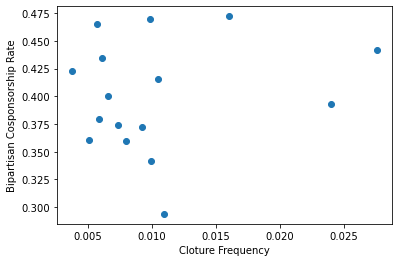

In [13]:
# Relationship between cloture frequency and bipartisan cosponsorship
fig = plt.figure()
X = np.vstack(clotures)
y = np.array(bipartisan_cosponsorship)
plt.xlabel('Cloture Frequency')
plt.ylabel('Bipartisan Cosponsorship Rate')
plt.scatter(X, y)
fig.show()
print(stats.pearsonr(clotures, bipartisan_cosponsorship))

(0.20656694598034897, 0.4427378108581604)


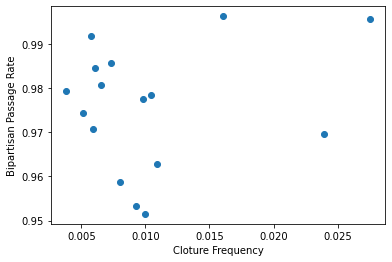

In [14]:
# Relationship between cloture frequency and bipartisan passage
fig = plt.figure()
X = np.vstack(clotures)
y = np.array(bipartisan_passage)
plt.xlabel('Cloture Frequency')
plt.ylabel('Bipartisan Passage Rate')
plt.scatter(X, y)
fig.show()
print(stats.pearsonr(clotures, bipartisan_passage))

(-0.655211250833027, 0.0058684192770414294)


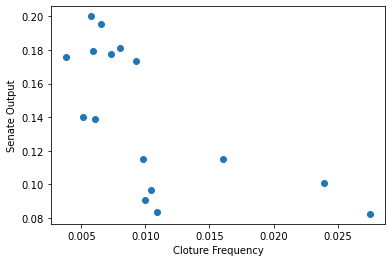

In [15]:
# Relationship between cloture frequency and Senate output
fig = plt.figure()
X = np.vstack(clotures)
y = np.array(output)
plt.xlabel('Cloture Frequency')
plt.ylabel('Senate Output')
plt.scatter(X, y)
fig.show()
print(stats.pearsonr(clotures, output))

(-0.70916248943486, 0.002096640590785117)


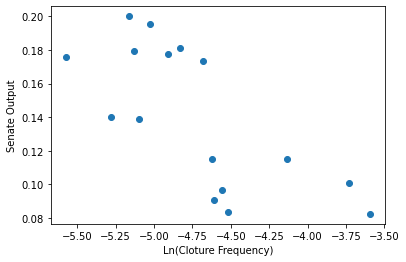

In [16]:
# Relationship between ln(cloture frequency) and Senate output
fig = plt.figure()
X = np.vstack(np.log(clotures))
y = np.array(output)
plt.xlabel('Ln(Cloture Frequency)')
plt.ylabel('Senate Output')
plt.scatter(X, y)
fig.show()
print(stats.pearsonr(np.log(clotures), output))

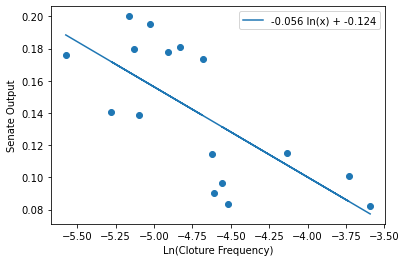

In [17]:
# Linear regression
X = np.vstack(np.log(clotures))
y = np.array(output)
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg_pred = reg.predict(X)
plt.xlabel('Ln(Cloture Frequency)')
plt.ylabel('Senate Output')
plt.scatter(np.log(clotures), output)
plt.plot(np.log(clotures),
         reg_pred,
         label = f'{reg.coef_[0]:.3f} ln(x) + {reg.intercept_:.3f}')
plt.legend()
fig.show()

In [28]:
# Determines whether the primary sponsor of a bill is a member of the majority party
def majority_party_sponsor(congress_num, issue):
    bill_type, bill_num = issue.split(' ')
    if bill_type == 'H.R.':
        chamber = 'house'
    else:
        chamber = 'senate'
    bill = 'https://www.congress.gov/bill/' + str(congress_num) + 'th-congress/' + chamber + '-bill/' + bill_num + '/cosponsors'
    r = requests.get(bill, headers=header)
    bs = BeautifulSoup(r.content, 'html.parser')
    sponsor = str(bs.find(present_in_href("member/")))
    rep_primary_sponsor = re.search('\[R', sponsor)
    dem_primary_sponsor = re.search('\[D', sponsor) or re.search('\[I', sponsor)
    num_reps = int(senate[senate['Congress'] == congress_num]['Republicans'])
    if num_reps >= 50:
        if rep_primary_sponsor:
            return True
        else:
            return False
    else:
        if dem_primary_sponsor:
            return True
        else:
            return False

# Determines whether a vote is opposed primarily by the minority party
# (majority of 'nay' votes are minority party members)
def opposed_by_minority_party(congress_num, session_num, vote_num):
    if vote_num < 10:
        vote_num = '00' + str(vote_num)
    elif vote_num < 100:
        vote_num = '0' + str(vote_num)
    else:
        vote_num = str(vote_num)
    vote = "https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=" + str(congress_num) + "&session=" + str(session_num) + "&vote=00" + vote_num
    r = requests.get(vote, headers=header)
    bs = BeautifulSoup(r.content, 'html.parser')
    roll_calls = bs.find_all(class_="newspaperDisplay_3column")
    try:
        nay_votes = str(roll_calls[2])
    except:
        if roll_calls:
            print('no nay votes: ' + str(congress_num) + ', ' + str(session_num) + ', ' + vote_num)
            return False
        else:
            print('broken link: ' + str(congress_num) + ', ' + str(session_num) + ', ' + vote_num)
            return False
    for x in bs.find_all(class_="contenttext"):
        if str(x).count('NAYs') > 0:
            nay_vote_text = str(x)
    nays = int(re.findall(r'\d+', nay_vote_text)[0])
    rep_nays = nay_votes.count('(R')
    dem_nays = nay_votes.count('(D') + nay_votes.count('(I')
    num_reps = int(senate[senate['Congress'] == congress_num]['Republicans'])
    if num_reps >= 50:
        if dem_nays / nays >= 0.5:
            return True
        else:
            return False
    else:
        if rep_nays / nays >= 0.5:
            return True
        else:
            return False
    return (rep_nays, dem_nays, nays)

In [19]:
# Find number of filibustered bills whose primary sponsor is a majority party member
num_maj_party_filibustered_bills = []
for congress in range(101, 117):
    filibustered_bills = filibustered_bills_dfs[congress-101]
    maj_party_is_primary_sponsor = []
    for issue in filibustered_bills['Issue']:
        maj_party_is_primary_sponsor.append(majority_party_sponsor(congress, issue))
    filibustered_bills_dfs[congress-101]['Majority Party Bill'] = maj_party_is_primary_sponsor
    num_maj_party_filibustered_bills.append(sum(maj_party_is_primary_sponsor))
    
senate['Majority Party Filibustered Bills'] = num_maj_party_filibustered_bills
senate['Minority Party Filibustered Bills'] = senate['Filibustered Bills'] - senate['Majority Party Filibustered Bills']

In [29]:
# Find majority bills that were primarily opposed by the minority party
num_maj_party_bills_opposed_by_min_party = []
for i in range(len(filibustered_bills_dfs)):
    maj_party_bills_opposed_by_min_party = []
    df = filibustered_bills_dfs[i]
    for row in range(len(df)):
        session_num = df.iloc[row, 5]
        vote_num = df.iloc[row, 6]
        majority_party_bill = df.iloc[row, 7]
        if not majority_party_bill:
            continue
        maj_party_bills_opposed_by_min_party.append(opposed_by_minority_party(101 + i, session_num, vote_num))
    num_maj_party_bills_opposed_by_min_party.append(sum(maj_party_bills_opposed_by_min_party))
    
senate['Majority Party Bills Opposed by Minority Party'] = num_maj_party_bills_opposed_by_min_party

no nay votes: 104, 2, 107
no nay votes: 105, 1, 057
no nay votes: 106, 2, 229
no nay votes: 107, 1, 262
broken link: 107, 1, 230
no nay votes: 109, 1, 103
no nay votes: 113, 2, 060


In [21]:
table_5 = senate[['Congress', 'Filibustered Bills', 'Majority Party Filibustered Bills', 'Majority Party Bills Opposed by Minority Party', 'Minority Party Filibustered Bills']]
table_5.to_csv('filibuster_table_5.csv')

In [22]:
# Counts of Senate-introduced bills by party and chamber of origin
rep_int_s = [1211, 1285, 911, 1314, 1588, 1833, 1304, 1478, 2209, 1260, 1129, 944, 1008, 1818, 1761, 2174]
dem_int_s = [2060, 2105, 1658, 885, 1067, 1454, 1877, 1557, 1913, 2481, 2930, 2772, 2012, 1730, 2044, 2912]
rep_int_hr = [87, 77, 45, 418, 444, 567, 447, 491, 494, 212, 148, 386, 449, 594, 765, 202]
dem_int_hr = [505, 539, 479, 75, 86, 140, 118, 127, 121, 731, 574, 105, 132, 179, 233, 575]
# Counts of Senate-approved bills by party and chamber of origin
rep_pass_s = [94, 84, 64, 172, 237, 278, 94, 257, 245, 62, 22, 43, 41, 130, 162, 160]
dem_pass_s = [241, 278, 194, 54, 71, 97, 121, 123, 92, 150, 150, 104, 111, 65, 99, 102]
rep_pass_hr = [54, 44, 27, 218, 224, 311, 231, 259, 248, 79, 42, 151, 146, 148, 207, 64]
dem_pass_hr = [290, 313, 251, 41, 34, 93, 74, 91, 79, 246, 219, 51, 64, 75, 84, 157]
# Counts of Senate-rejected bills by party
rep_fail = [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
dem_fail = [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

bill_info_by_party = pd.DataFrame.from_dict(
    {'Rep Introduced (S)': rep_int_s,
     'Dem Introduced (S)': dem_int_s,
     'Rep Introduced (HR)': rep_int_hr,
     'Dem Introduced (HR)': dem_int_hr,
     'Rep Passed (S)': rep_pass_s,
     'Dem Passed (S)': dem_pass_s,
     'Rep Passed (HR)': rep_pass_hr,
     'Dem Passed (HR)': dem_pass_hr,
     'Rep Failed': rep_fail,
     'Dem Failed': dem_fail})

bill_info_by_party.insert(0, 'Republicans', [45, 44, 43, 52, 55, 55, 50, 51, 55, 49, 41, 47, 45, 54, 51, 53])
bill_info_by_party.insert(1, 'Democrats', 100 - bill_info_by_party['Republicans'])
bill_info_by_party['Rep Introduced'] = bill_info_by_party['Rep Introduced (S)'] + bill_info_by_party['Rep Introduced (HR)']
bill_info_by_party['Dem Introduced'] = bill_info_by_party['Dem Introduced (S)'] + bill_info_by_party['Dem Introduced (HR)']
bill_info_by_party['Rep Received Floor Vote'] = bill_info_by_party['Rep Passed (S)'] + bill_info_by_party['Rep Passed (HR)'] + bill_info_by_party['Rep Failed']
bill_info_by_party['Dem Received Floor Vote'] = bill_info_by_party['Dem Passed (S)'] + bill_info_by_party['Dem Passed (HR)'] + bill_info_by_party['Dem Failed']
bill_info_by_party['Rep Output'] = bill_info_by_party['Rep Received Floor Vote'] / bill_info_by_party['Rep Introduced']
bill_info_by_party['Dem Output'] = bill_info_by_party['Dem Received Floor Vote'] / bill_info_by_party['Dem Introduced']

df = bill_info_by_party[['Democrats', 'Rep Output', 'Dem Output', 'Rep Received Floor Vote', 'Dem Received Floor Vote']]

# Compute majority party and minority party outputs
maj_party_outputs = []
for i in range(16):
    if df.iloc[i, 0] > 50:
        maj_party_output = df.iloc[i, 2]
    else:
        maj_party_output = df.iloc[i, 1]
    maj_party_outputs.append(maj_party_output)

min_party_outputs = []
for i in range(16):
    if df.iloc[i, 0] <= 50:
        min_party_output = df.iloc[i, 2]
    else:
        min_party_output = df.iloc[i, 1]
    min_party_outputs.append(min_party_output)

senate['Majority Party Output'] = maj_party_outputs
senate['Minority Party Output'] = min_party_outputs

In [23]:
maj_party_output = pd.Series(senate['Majority Party Output']).astype('float64')
min_party_output = pd.Series(senate['Minority Party Output']).astype('float64')

(-0.6622214989833941, 0.005191651164380099)


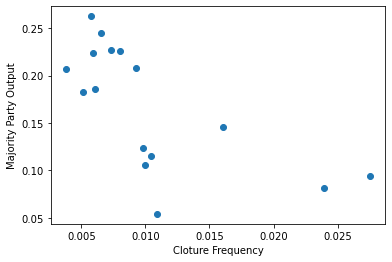

In [24]:
# Relationship between cloture frequency and majority party output
fig = plt.figure()
X = np.vstack(clotures)
y = np.array(maj_party_output)
plt.xlabel('Cloture Frequency')
plt.ylabel('Majority Party Output')
plt.scatter(X, y)
fig.show()
print(stats.pearsonr(clotures, maj_party_output))

(-0.714597692211722, 0.0018670937091040869)


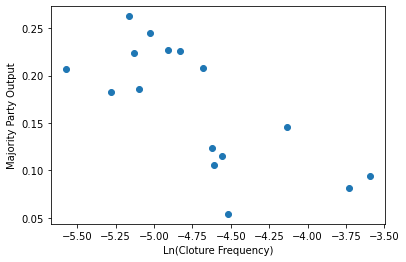

In [25]:
# Relationship between ln(cloture frequency) and majority party output
fig = plt.figure()
X = np.vstack(np.log(clotures))
y = np.array(maj_party_output)
plt.xlabel('Ln(Cloture Frequency)')
plt.ylabel('Majority Party Output')
plt.scatter(X, y)
fig.show()
print(stats.pearsonr(np.log(clotures), maj_party_output))

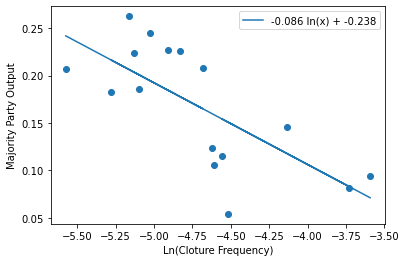

In [26]:
# Linear regression
X = np.vstack(np.log(clotures))
y = np.array(maj_party_output)
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg_pred = reg.predict(X)
plt.xlabel('Ln(Cloture Frequency)')
plt.ylabel('Majority Party Output')
plt.scatter(np.log(clotures), maj_party_output)
plt.plot(np.log(clotures),
         reg_pred,
         label = f'{reg.coef_[0]:.3f} ln(x) + {reg.intercept_:.3f}')
plt.legend()
fig.show()

(-0.10124779614224264, 0.7090738190014738)


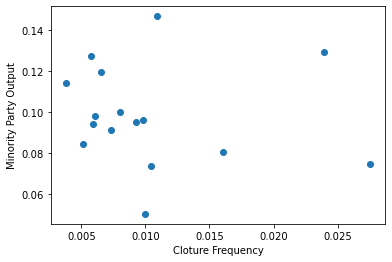

In [27]:
# Relationship between cloture frequency and minority party output
fig = plt.figure()
X = np.vstack(clotures)
y = np.array(min_party_output)
plt.xlabel('Cloture Frequency')
plt.ylabel('Minority Party Output')
plt.scatter(X, y)
fig.show()
print(stats.pearsonr(clotures, min_party_output))